In [53]:
import pickle
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.experimental import enable_halving_search_cv
from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    cross_val_predict,
    RandomizedSearchCV,
    HalvingRandomSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
)
from xgboost import XGBClassifier
from pathlib import Path
import category_encoders as ce
import optuna
from pycaret.classification import load_model, ClassificationExperiment
from mlutils.classification import classifier_param_grid,classifier_plots

In [2]:
SEED = 1990
MODEL_REPO = 'models/'

### Read Data

In [3]:
with open('classification_data.pkl', 'rb') as f:
    data = pickle.load(f)
data.keys()

dict_keys(['dataset', 'X_train', 'X_test', 'y_train', 'y_test', 'train', 'test'])

In [4]:
train, test = data['train'], data['test']

In [5]:
test.target.value_counts(normalize=True)

0    0.7
1    0.3
Name: target, dtype: float64

### Agenda

* PyCaret Classification Documentation [here](https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.setup)
* Experiment from scratch
* Load ready-to-serve pipeline
* Load configured preprocessors
* Load trained pipelines
* Deploy with PyCaret

### Experiment from scratch

In [7]:
train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,color,size,target
239,-0.297640,0.909344,1.456595,0.165097,-1.040779,red,large,1
502,-0.452870,-1.208686,-2.174879,1.703699,0.941549,green,medium,0
150,-0.182613,-1.119435,-2.163882,1.548175,1.119833,blue,small,0
97,2.089710,1.191604,0.069651,0.544277,1.387935,blue,large,0
407,-0.875101,-1.458798,-2.085463,1.319194,0.601526,blue,medium,0


In [6]:
e0 = ClassificationExperiment()

In [11]:
e0.setup(
    data=train,
    test_data=test,
    numeric_features=['feature_0','feature_1','feature_2','feature_3','feature_4'],
    categorical_features=['color','size'],
    preprocess=True,
    numeric_imputation='mean',
    categorical_imputation='mode',
    max_encoding_ohe=25,
    encoding_method=ce.CatBoostEncoder,
    bin_numeric_features=None,
    remove_outliers=True,
    outliers_method='iforest',
    transformation=True,
    transformation_method='yeo-johnson',
    normalize=True,
    normalize_method='minmax',
    fold=10,
    fold_strategy='stratifiedkfold',
    fold_shuffle=True,
    session_id=SEED,
    experiment_name="from_scratch"
    )

,Description,Value
0,Session id,1990
1,Target,target
2,Target type,Binary
3,Original data shape,"(1000, 8)"
4,Transformed data shape,"(962, 12)"
5,Transformed train set shape,"(712, 12)"
6,Transformed test set shape,"(250, 12)"
7,Numeric features,5
8,Categorical features,2
9,Preprocess,True


In [12]:
topXmodels = e0.compare_models(n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8693,0.9404,0.7018,0.8395,0.7607,0.6723,0.6801,0.1500
rf,Random Forest Classifier,0.8640,0.9420,0.7241,0.8100,0.7589,0.6653,0.6717,0.1650
et,Extra Trees Classifier,0.8547,0.9363,0.6927,0.7979,0.7361,0.6374,0.6442,0.1590
lightgbm,Light Gradient Boosting Machine,0.8520,0.9386,0.7332,0.7650,0.7445,0.6410,0.6446,0.1400
xgboost,Extreme Gradient Boosting,0.8493,0.9352,0.7281,0.7664,0.7394,0.6345,0.6408,0.1410
ada,Ada Boost Classifier,0.8413,0.9258,0.6976,0.7696,0.7220,0.6126,0.6218,0.1380
knn,K Neighbors Classifier,0.8320,0.8810,0.6073,0.7811,0.6771,0.5677,0.5791,0.1340
dt,Decision Tree Classifier,0.8307,0.8016,0.7289,0.7114,0.7168,0.5964,0.5995,0.1270
qda,Quadratic Discriminant Analysis,0.8160,0.9275,0.8492,0.6544,0.7353,0.5990,0.6155,0.1290
lda,Linear Discriminant Analysis,0.8160,0.8899,0.6704,0.7046,0.6862,0.5562,0.5572,0.1270


In [15]:
compare_models_df = e0.pull()
compare_models_df

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8693,0.9404,0.7018,0.8395,0.7607,0.6723,0.6801,0.150
rf,Random Forest Classifier,0.8640,0.9420,0.7241,0.8100,0.7589,0.6653,0.6717,0.165
et,Extra Trees Classifier,0.8547,0.9363,0.6927,0.7979,0.7361,0.6374,0.6442,0.159
lightgbm,Light Gradient Boosting Machine,0.8520,0.9386,0.7332,0.7650,0.7445,0.6410,0.6446,0.140
xgboost,Extreme Gradient Boosting,0.8493,0.9352,0.7281,0.7664,0.7394,0.6345,0.6408,0.141
ada,Ada Boost Classifier,0.8413,0.9258,0.6976,0.7696,0.7220,0.6126,0.6218,0.138
knn,K Neighbors Classifier,0.8320,0.8810,0.6073,0.7811,0.6771,0.5677,0.5791,0.134
dt,Decision Tree Classifier,0.8307,0.8016,0.7289,0.7114,0.7168,0.5964,0.5995,0.127
qda,Quadratic Discriminant Analysis,0.8160,0.9275,0.8492,0.6544,0.7353,0.5990,0.6155,0.129
lda,Linear Discriminant Analysis,0.8160,0.8899,0.6704,0.7046,0.6862,0.5562,0.5572,0.127


In [18]:
tuned_models = [e0.tune_model(x,
                              return_train_score=True) for x in topXmodels]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [19]:
ensembled = [e0.ensemble_model(x, return_train_score=True) for x in tuned_models]

In [22]:
blender = e0.blend_models(ensembled, return_train_score=True)

In [24]:
blender

VotingClassifier(estimators=[('str',
                              BaggingClassifier(base_estimator='deprecated',
                                                bootstrap=True,
                                                bootstrap_features=False,
                                                estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                                     criterion='friedman_mse',
                                                                                     init=None,
                                                                                     learning_rate=0.005,
                                                                                     loss='log_loss',
                                                                                     max_depth=10,
                                                                                     max_features=1.0,
                                                                                     max_leaf_nodes=None,
                                                                                     min_impurity_decrease=0,
                                                                                     min_samples_leaf=5,
                                                                                     min_samples_s...
                                                                        min_child_weight=None,
                                                                        missing=nan,
                                                                        monotone_constraints=None,
                                                                        n_estimators=100,
                                                                        n_jobs=-1,
                                                                        num_parallel_tree=None,
                                                                        objective='binary:logistic',
                                                                        predictor=None, ...),
                                                max_features=1.0,
                                                max_samples=1.0,
                                                n_estimators=10, n_jobs=None,
                                                oob_score=False,
                                                random_state=1990, verbose=0,
                                                warm_start=False))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='soft', weights=None)

In [23]:
stacker = e0.stack_models(ensembled, return_train_score=True)

In [25]:
stacker

StackingClassifier(cv=5,
                   estimators=[('str',
                                BaggingClassifier(base_estimator='deprecated',
                                                  bootstrap=True,
                                                  bootstrap_features=False,
                                                  estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                                       criterion='friedman_mse',
                                                                                       init=None,
                                                                                       learning_rate=0.005,
                                                                                       loss='log_loss',
                                                                                       max_depth=10,
                                                                                       max_features=1.0,
                                                                                       max_leaf_nodes=None,
                                                                                       min_impurity_decrease=0,
                                                                                       min_samples_leaf=5,
                                                                                       min_sa...
                                                  random_state=1990, verbose=0,
                                                  warm_start=False))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=1000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=1990,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                   n_jobs=-1, passthrough=False, stack_method='auto',
                   verbose=0)

In [28]:
train_preds = e0.predict_model(stacker,data=train)
test_preds = e0.predict_model(stacker)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9627,0.9938,0.9200,0.9539,0.9367,0.9102,0.9105


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9120,0.9666,0.8133,0.8841,0.8472,0.7856,0.7869


In [42]:
train_preds['prediction_probas_0'] = np.where(
    train_preds.prediction_label==1,
    1-train_preds.prediction_score,
    train_preds.prediction_score
)

train_preds['prediction_probas_1'] = np.where(
    train_preds.prediction_label==1,
    train_preds.prediction_score,
    1-train_preds.prediction_score
)

test_preds['prediction_probas_0'] = np.where(
    test_preds.prediction_label==1,
    1-test_preds.prediction_score,
    test_preds.prediction_score
)

test_preds['prediction_probas_1'] = np.where(
    test_preds.prediction_label==1,
    test_preds.prediction_score,
    1-test_preds.prediction_score
)

y_train = train_preds['target']
y_train_probas = train_preds[['prediction_probas_0','prediction_probas_1']].values

y_test = test_preds['target']
y_test_probas = test_preds[['prediction_probas_0','prediction_probas_1']].values

{'confmat': <Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>,
 'roc': <Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 'pr': <Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>,
 'cal': <Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>,
 'ks': <Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>,
 'lift': <Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>,
 'gains': <Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>}

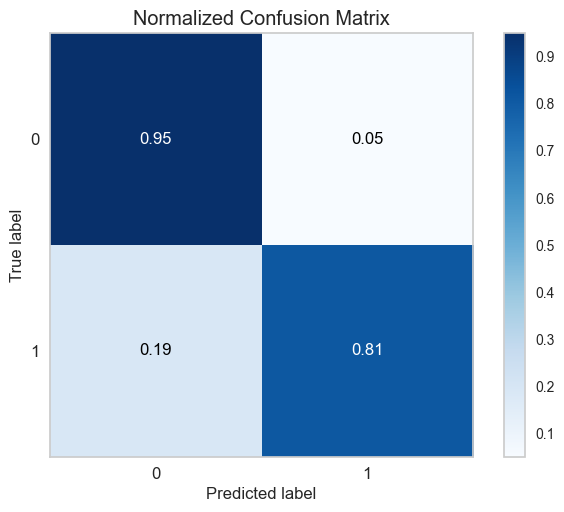

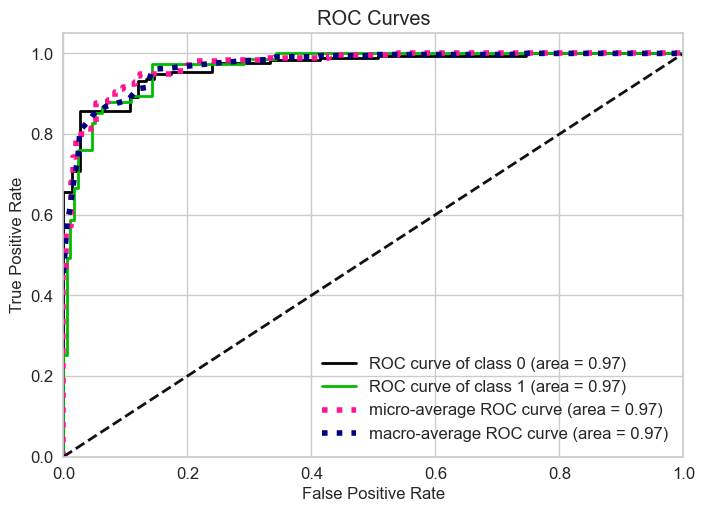

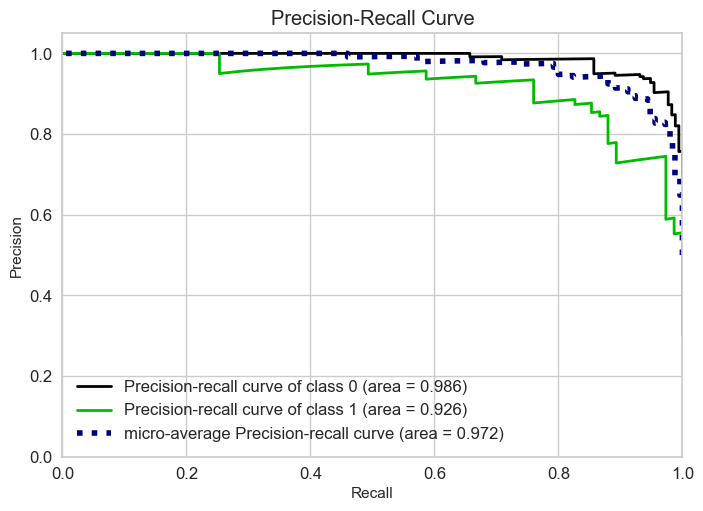

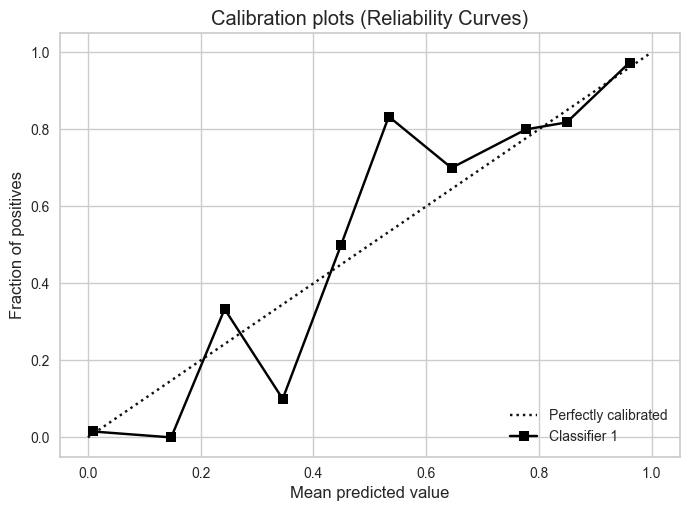

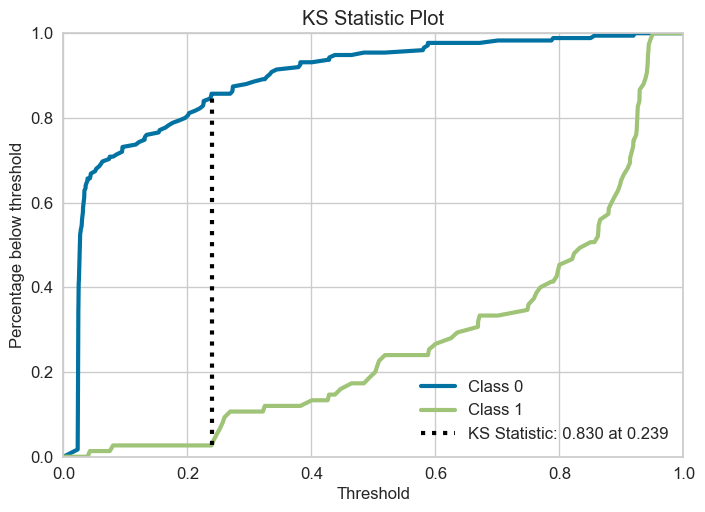

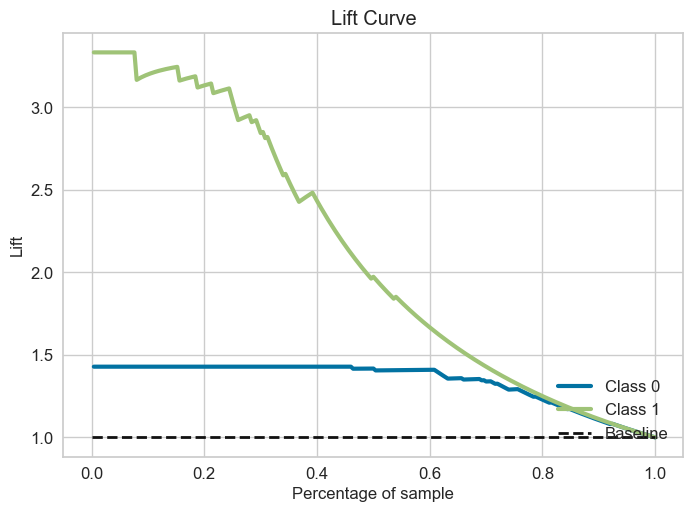

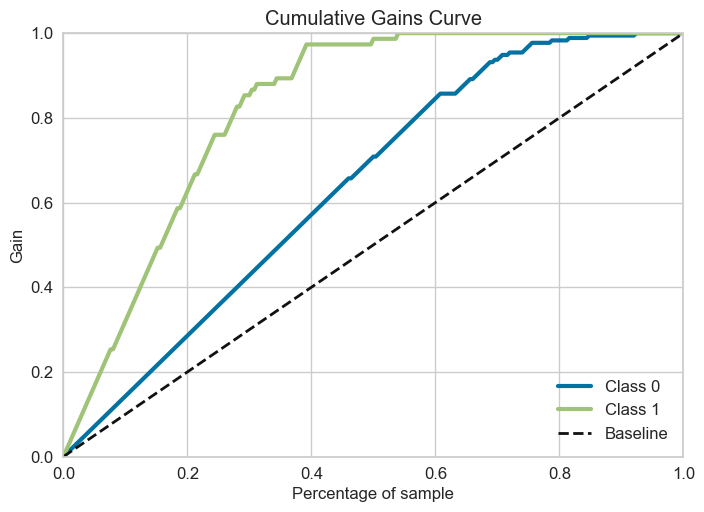

In [48]:
classifier_plots(y_test,y_test_probas)

In [ ]:
calibrated = e0.calibrate_model(stacker,return_train_score=True)

### Load ready-to-serve pipeline

In [9]:
e1 = ClassificationExperiment()

e1.setup(data=train,
         test_data=test,
         preprocess=False,
         fold_strategy='stratifiedkfold',
         fold=10,
         session_id=SEED,
         experiment_name="custom_model"
        )

params_grid = {
    "clf__n_estimators": [100, 150, 200],
    "clf__learning_rate": [0.01, 0.1, 0.5],
    "clf__max_depth": [3, 5, 7],
    "clf__min_child_weight": [1, 3, 5],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma": [0.1, 0.3, 0.5],
    "clf__reg_alpha": [0.1, 0.25, 0.75],
    "clf__reg_lambda": [0.1, 0.25, 0.75],
}

pretrained = e1.load_model(f'{MODEL_REPO}modelfit')

# tuned1 = e1.tune_model(pretrained,
#                        custom_grid = params_grid,
#                        n_iter = 20,
#                        search_library = 'scikit-learn',
#                        search_algorithm = 'random', 
#                        return_train_score = True)

tuned2 = e1.tune_model(pretrained,
                       custom_grid = params_grid,
                       n_iter = 20,
                       search_library = 'optuna',
                       search_algorithm = 'tpe', 
                       return_train_score = True)

tuned2.named_steps['clf'].get_params()

In [24]:
tuned2.named_steps['clf']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

### Load trained pipelines

In [6]:
e2 = ClassificationExperiment()

e2.setup(
    data=train,
    test_data=test,
    preprocess=False,
    fold_strategy='stratifiedkfold',
    fold=10,
    session_id=SEED,
    experiment_name="loaded_pipelines"
)

In [8]:
# covert string path into Path
model_repo = Path(MODEL_REPO)
print(model_repo)

# capture all models of a certain pattern
model_repo_list = list(model_repo.glob('*pipe_*'))
model_repo_list_no_suffix = [str(x).replace(".pkl","") for x in model_repo_list]
model_repo_list_no_suffix

models


['models/pipe_LGBMClassifier',
 'models/pipe_XGBClassifier',
 'models/pipe_KNeighborsClassifier',
 'models/pipe_LogisticRegression',
 'models/pipe_RandomForestClassifier',
 'models/pipe_GradientBoostingClassifier',
 'models/pipe_AdaBoostClassifier']

In [ ]:
loaded_models = [e2.load_model(x) for x in model_repo_list_no_suffix]

tuned_models = []
for lm in loaded_models:

    temp_clf_name = lm.steps[-1][0]    
    temp_grid = classifier_param_grid(lm)
    temp_clf_grid = {f"{temp_clf_name}__k":v for k,v in temp_grid.items()}
    
    temp_tuned_model = e2.tune_model(lm,
                                     custom_grid = temp_clf_grid,
                                     n_iter = 10,
                                     search_library = 'optuna',
                                     search_algorithm = 'tpe', 
                                     return_train_score = True)
    
    tuned_models.append(temp_tuned_model)
    

In [ ]:
blender = e2.blend_models(tuned_models,
                          choose_better=True,
                          return_train_score=True)

stacker = e2.stack_models(tuned_models,
                          choose_better=True,
                          return_train_score=True
                         )

### Load configured preprocessors

In [21]:
fitted_prepro = fitted_model.named_steps['prp']
fitted_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('numeric',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28586c7f0>),
                                ('cat',
                                 Pipeline(steps=[('categorical',
                                                  CatBoostEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28586c9d0>)])

In [22]:
e3 = Classificatione3eriment()

e3.setup(data=train,
          test_data=test,
          preprocess=False,
          custom_pipeline=[fitted_prepro],
          fold_strategy='stratifiedkfold',
          fold=10,
          session_id=SEED,
          e3eriment_name="custom_prepro"
          )

n_select = e3.models().shape[0]
print(f'{n_select=}')
e3.models()

modelboard = e3.compare_models(n_select=n_select)

modelboard

modelboarddf = e3.pull()
modelboarddf

# ensembled_models = [e3.ensemble_model(m, choose_better=True) for m in tuned_models]

tuned_models = [e3.tune_model(m,
                               search_library='optuna',
                               search_algorithm='tpe'
                              ) 
                for m in modelboard[:3]]

blender = e3.blend_models(tuned_models,
#                            choose_better=True,
                           return_train_score=True
                          )

blender

stacker = e3.stack_models(tuned_models,
#                            choose_better=True,
                           return_train_score=True
                          )

stacker

# pd.DataFrame(fitted_prepro.transform(X_train))
# e3.pipeline.transform(X_train)
# fitted_prepro.output_indices_
# e3.pipeline.named_steps['custom_step_0'].transformer.output_indices_

pycaret_model = Pipeline([('prepro',e3.pipeline),('clf',stacker)])

pycaret_model

In [ ]:
pycaret_model.predict(X_train)

### Deploy with PyCaret

In [ ]:
e0.create_api(stacker, 'classification_service')

In [ ]:
!python classification_service.py

In [ ]:
e0.create_docker(pycaret_model, 'classification_service')